# Using Word2Vec for prediction
------------------------------------

In this example, we will load our prior CBOW trained embeddings to perform logistic regression model for movie review predictions.

From this data set we will compute/fit the CBOW model of the Word2Vec Algorithm.

As a pre-requisite, be sure to have run the prior recipe in section 5 of this chapter, '05_Working_With_CBOW.py'.  This will train and save the word2vec-CBOW embeddings.

We start by loading the necessary libraries.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

Next we start a computational graph session.

In [2]:
sess = tf.Session()

Declare model parameters.  An important note here is that the `embedding_size` must be the same size as we set during training in the CBOW example.

In [3]:
embedding_size = 200  # If you change this, you must change it in the CBOW tutorial and retrain.
vocabulary_size = 2000
batch_size = 100
max_words = 100

Next, we declare our stop words, load the data, and normalize the text.

In [4]:
# Declare stop words
stops = stopwords.words('english')

# Load Data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
print('Done.')

Loading Data
Normalizing Text Data


Split the data set into train/test.

In [5]:
train_indices = np.random.choice(len(target), round(0.8*len(target)), replace=False)
test_indices = np.array(list(set(range(len(target))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

Next we load the dictionary file, and convert the review texts into indices and pad/crop them to a fixed length.

In [9]:
# Load dictionary and embedding matrix
dict_file = os.path.join( '..', '05_Working_With_CBOW_Embeddings', 'temp', 'movie_vocab.pkl')
word_dictionary = pickle.load(open(dict_file, 'rb'))

# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

Now we create the model.  Note that won't matter what we initialize the embedding variable to, because we will overwrite it from the saved CBOW embeddings from the prior recipe.

In [10]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Define model:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_words], dtype=tf.int32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Lookup embeddings vectors
embed = tf.nn.embedding_lookup(embeddings, x_data)
# Take average of all word embeddings in documents
embed_avg = tf.reduce_mean(embed, 1)

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(embed_avg, A), b)

print('Done.')

Creating Model


Now we can declare our loss function, predictions function, optimization, and intialize the variables.

After that we will load the model embeddings.

In [11]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
my_opt = tf.train.AdagradOptimizer(0.005)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Load model embeddings
model_checkpoint_path = os.path.join( '..', '05_Working_With_CBOW_Embeddings',
                                     'temp','cbow_movie_embeddings.ckpt')
saver = tf.train.Saver({"embeddings": embeddings})
saver.restore(sess, model_checkpoint_path)

Now we can start training our logistic regression.

In [12]:
# Start Logistic Regression
print('Starting Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=batch_size)
    rand_x = text_data_train[rand_index]
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Model Training
Generation # 500. Train Loss (Test Loss): 0.72 (0.70). Train Acc (Test Acc): 0.43 (0.51)
Generation # 1000. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.56 (0.51)
Generation # 1500. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.56 (0.51)
Generation # 2000. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.44 (0.51)
Generation # 2500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.48 (0.51)
Generation # 3000. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.57 (0.50)
Generation # 3500. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.40 (0.52)
Generation # 4000. Train Loss (Test Loss): 0.71 (0.70). Train Acc (Test Acc): 0.46 (0.51)
Generation # 4500. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc): 0.55 (0.51)
Generation # 5000. Train Loss (Test Loss): 0.70 (0.70). Train Acc (Test Acc): 0.51 (0.52)
Generation # 5500. Train Loss (Test Loss): 0.69 (0.70). Train Acc (Test Acc):

Here is the matplotlib code to plot the train/test loss and accuracy over the iterations.

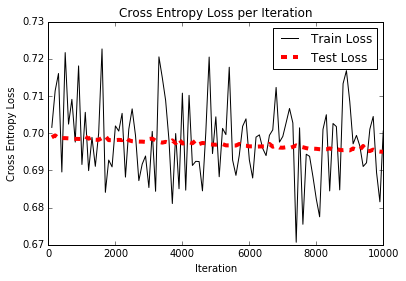

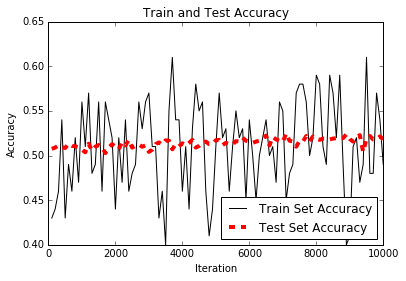

In [13]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Our predictions are not very accurate.  More time must be spent in tuning the CBOW embeddings.  We can also try to deepen our model structure as well.

Also, sentiment analysis is really hard.